In [1]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "del_mc1"

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import KFold
from config import default_config
import torch.optim as optim
import numpy as np

import wandb

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="del_mc1"


#### Downloading Datasets

In [2]:
unnormalized_transform = transforms.Compose([
    transforms.ToTensor()
])

unnormalized_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=unnormalized_transform)

def calculate_mean_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in dataloader:
        for i in range(3):  # Loop through each channel
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

mean, std = calculate_mean_std(unnormalized_trainset)
print("Mean: ", mean)
print("Std: ", std)

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalized_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalized_transform)

Files already downloaded and verified
Mean:  tensor([0.4915, 0.4822, 0.4466])
Std:  tensor([0.2463, 0.2428, 0.2607])
Files already downloaded and verified
Files already downloaded and verified


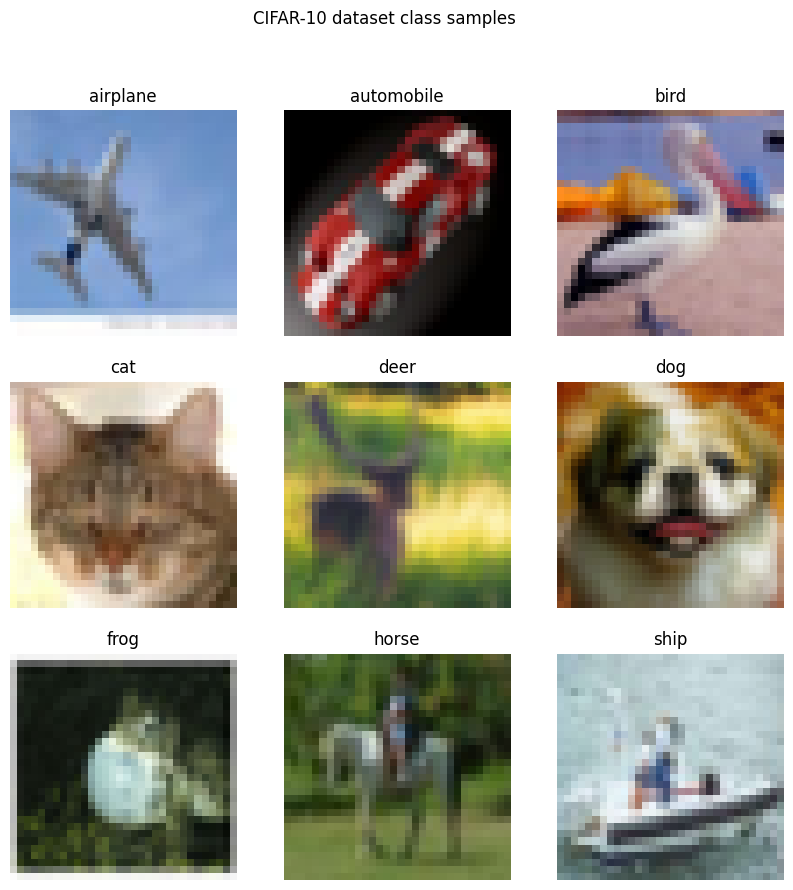

In [3]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) < 10:
    index = np.random.randint(0, len(cifar_trainset))
    image, label = cifar_trainset[index]
    if label not in independent_class_images:
        independent_class_images[label] = image

def reverse_normalize(tensor_img, mean, std):
    mean = mean.numpy()
    std = std.numpy()

    rev_img = tensor_img.numpy().transpose((1, 2, 0))
    rev_img = rev_img * std + mean
    rev_img = np.clip(rev_img, 0, 1)
    return rev_img

idx = 0
for i in range(3):
    for j in range(3):
        if idx in independent_class_images:
            img_to_plot = reverse_normalize(independent_class_images[idx], mean, std)
            axs[i, j].imshow(img_to_plot)
            axs[i, j].set_title(cifar_trainset.classes[idx])
            axs[i, j].axis('off')
        idx += 1

plt.show()

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Base Functions

In [5]:
def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int =1):
    acc = MulticlassAccuracy(num_classes=n_classes, device=device)

    running_loss = 0.0
    verbose_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        acc.update(outputs, labels)
        running_loss += loss.item()
        verbose_loss += loss.item()
        
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[Epoch {current_epoch}, {i + 1}] loss: {verbose_loss / verbose_interval:.3f}')
            verbose_loss = 0.0
    
    train_loss = running_loss / len(data_loader)

    return {"train_accuracy": acc.compute(), "train_loss": train_loss}

In [6]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int
         ):
    accuracy = MulticlassAccuracy(num_classes=n_classes, device=device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)

            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader.dataset)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

In [7]:
def assess_model(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=default_config,
                 weight_init: str = 'kaiming',
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                 run_name: str = None,
                 tags: list[str] = None,
                 verbose: bool = False
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if weight_init == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight)
            elif weight_init == 'xavier':
                torch.nn.init.xavier_normal_(m.weight)
            elif weight_init == 'normal':
                mean = m.weight.mean().item()
                std = m.weight.std().item()
                torch.nn.init.normal_(m.weight, mean, std)
            else:
                raise ValueError(f"Unknown weight initialization method: {weight_init}")

    with wandb.init(project="del-mc1", 
                    name=run_name if run_name is not None else model.__class__.__name__, 
                    config=default_config,
                    tags=tags if tags is not None else None,
                    settings=wandb.Settings(disable_job_creation=True)
                    ) as run:
        use_cuda = torch.cuda.is_available()

        device = torch.device("cuda" if use_cuda else "cpu")
        model.to(device)
        print(f"--- Running Experiment {run_name} ---")
        torch.manual_seed(config["seed"]) 

        for epoch in range(1, n_epochs + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch, verbose=verbose)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log({**train_metrics, **test_metrics, "epoch": epoch})    
            print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")

        print(f"View run at: https://wandb.ai/{run.entity}/{run.project}/{run.id}")
        print()


In [8]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False)

## Base Model

In [9]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(4096 , 512),
        nn.ReLU(),
        nn.Linear(512, 10)
        # no softmax here, since we will use cross-entropy as activation and torch will apply it for us
    )

### Customizable Base Model
For the following experiments and analyses, this following function will help to configure new models based on the `BaseCNN`.

In [10]:
def CustomBaseCNN(num_conv_layers=1,
                  filters_per_layer=[16], 
                  kernel_sizes=[3], 
                  strides=[1],
                  paddings=[1], 
                  num_fc_layers=2, 
                  fc_sizes=[512, 10],
                  use_dropout=False,
                  dropout_rate=0.5,
                  use_batchnorm=False,
                  batchnorm_momentum=0.1):
    layers = []

    input_channels = 3
    output_size = 32
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(input_channels, filters_per_layer[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i]))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(filters_per_layer[i], momentum=batchnorm_momentum))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.MaxPool2d(2, 2))
        input_channels = filters_per_layer[i]
        output_size = (output_size - kernel_sizes[i] + 2*paddings[i]) // strides[i] + 1
        output_size = output_size // 2

    layers.append(nn.Flatten())

    input_size = input_channels * output_size * output_size

    for i in range(num_fc_layers):
        layers.append(nn.Linear(input_size, fc_sizes[i]))
        if i < num_fc_layers - 1:
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            input_size = fc_sizes[i]

    return nn.Sequential(*layers)

## Overfit Testing

In [23]:
single_sample_subset = torch.utils.data.Subset(cifar_trainset, [0])
single_sample_loader = torch.utils.data.DataLoader(single_sample_subset, batch_size=1, shuffle=False)

assess_model(BaseCNN(), 
             nn.CrossEntropyLoss(),
             None, 
             single_sample_loader, 
             single_sample_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=3,
             n_classes=10,
             run_name="Overfit_Test")

--- Running Experiment Overfit_Test ---
Epoch 1 - Train accuracy: 0.000, Test accuracy: 1.000
Epoch 2 - Train accuracy: 1.000, Test accuracy: 1.000
Epoch 3 - Train accuracy: 1.000, Test accuracy: 1.000
View run at: https://wandb.ai/okaynils/del-mc1/bnxbkbrx



## Exploring Weight-Initialization

In [24]:
assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='kaiming',
             run_name="Kaiming_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='xavier',
             run_name="Xavier_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='normal',
             run_name="Normal_Init")

--- Running Experiment Kaiming_Init ---
Epoch 1 - Train accuracy: 0.423, Test accuracy: 0.493
Epoch 2 - Train accuracy: 0.537, Test accuracy: 0.532
Epoch 3 - Train accuracy: 0.588, Test accuracy: 0.552
Epoch 4 - Train accuracy: 0.623, Test accuracy: 0.586
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.679, Test accuracy: 0.581
Epoch 7 - Train accuracy: 0.703, Test accuracy: 0.597
Epoch 8 - Train accuracy: 0.728, Test accuracy: 0.622
Epoch 9 - Train accuracy: 0.748, Test accuracy: 0.611
Epoch 10 - Train accuracy: 0.770, Test accuracy: 0.636
View run at: https://wandb.ai/okaynils/del-mc1/y4wcrcsd

--- Running Experiment Xavier_Init ---
Epoch 1 - Train accuracy: 0.411, Test accuracy: 0.481
Epoch 2 - Train accuracy: 0.523, Test accuracy: 0.524
Epoch 3 - Train accuracy: 0.573, Test accuracy: 0.551
Epoch 4 - Train accuracy: 0.605, Test accuracy: 0.582
Epoch 5 - Train accuracy: 0.635, Test accuracy: 0.596
Epoch 6 - Train accuracy: 0.660, Test accuracy: 0.577

## Analyzing Model Depth

In [29]:
depth_3_mlp = CustomBaseCNN(num_fc_layers=3, fc_sizes=[4096, 512, 10])
depth_4_mlp = CustomBaseCNN(num_fc_layers=4, fc_sizes=[4096, 512, 256, 10])
depth_5_mlp = CustomBaseCNN(num_fc_layers=5, fc_sizes=[4096, 512, 256, 128, 10])

assess_model(model=depth_3_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Depth_3_MLP")

assess_model(model=depth_4_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Depth_4_MLP")

assess_model(model=depth_5_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Depth_5_MLP")

--- Running Experiment Depth_3_MLP ---
Epoch 1 - Train accuracy: 0.430, Test accuracy: 0.476
Epoch 2 - Train accuracy: 0.553, Test accuracy: 0.527
Epoch 3 - Train accuracy: 0.611, Test accuracy: 0.542
Epoch 4 - Train accuracy: 0.654, Test accuracy: 0.607
Epoch 5 - Train accuracy: 0.697, Test accuracy: 0.592
Epoch 6 - Train accuracy: 0.740, Test accuracy: 0.557
Epoch 7 - Train accuracy: 0.775, Test accuracy: 0.571
Epoch 8 - Train accuracy: 0.812, Test accuracy: 0.632
Epoch 9 - Train accuracy: 0.852, Test accuracy: 0.597
Epoch 10 - Train accuracy: 0.882, Test accuracy: 0.619
View run at: https://wandb.ai/okaynils/del-mc1/6iplgmxz

--- Running Experiment Depth_4_MLP ---
Epoch 1 - Train accuracy: 0.422, Test accuracy: 0.472
Epoch 2 - Train accuracy: 0.546, Test accuracy: 0.521
Epoch 3 - Train accuracy: 0.609, Test accuracy: 0.552
Epoch 4 - Train accuracy: 0.657, Test accuracy: 0.602
Epoch 5 - Train accuracy: 0.700, Test accuracy: 0.582
Epoch 6 - Train accuracy: 0.743, Test accuracy: 0.554


## Analyzing Number of Filters

In [31]:
filter_8_16_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[8, 16], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_16_32_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[16, 32], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_32_64_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[32, 64], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])

assess_model(model=filter_8_16_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Filter_8_16_CNN")

assess_model(model=filter_16_32_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Filter_16_32_CNN")

assess_model(model=filter_32_64_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Filter_32_64_CNN")

--- Running Experiment Filter_8_16_CNN ---
Epoch 1 - Train accuracy: 0.401, Test accuracy: 0.442
Epoch 2 - Train accuracy: 0.504, Test accuracy: 0.486
Epoch 3 - Train accuracy: 0.547, Test accuracy: 0.521
Epoch 4 - Train accuracy: 0.575, Test accuracy: 0.551
Epoch 5 - Train accuracy: 0.597, Test accuracy: 0.560
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.562
Epoch 7 - Train accuracy: 0.639, Test accuracy: 0.568
Epoch 8 - Train accuracy: 0.655, Test accuracy: 0.604
Epoch 9 - Train accuracy: 0.669, Test accuracy: 0.591
Epoch 10 - Train accuracy: 0.680, Test accuracy: 0.604
View run at: https://wandb.ai/okaynils/del-mc1/4f0vgm7l

--- Running Experiment Filter_16_32_CNN ---
Epoch 1 - Train accuracy: 0.424, Test accuracy: 0.478
Epoch 2 - Train accuracy: 0.540, Test accuracy: 0.525
Epoch 3 - Train accuracy: 0.588, Test accuracy: 0.567
Epoch 4 - Train accuracy: 0.623, Test accuracy: 0.597
Epoch 5 - Train accuracy: 0.651, Test accuracy: 0.595
Epoch 6 - Train accuracy: 0.674, Test accurac

## Analyzing Kernel Size

In [35]:
kernel_3_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[3], strides=[1], paddings=[1])
kernel_5_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[5], strides=[1], paddings=[2])
kernel_7_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[7], strides=[1], paddings=[3])

assess_model(model=kernel_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Kernel_3_CNN")

assess_model(model=kernel_5_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Kernel_5_CNN")

assess_model(model=kernel_7_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Kernel_7_CNN")


--- Running Experiment Kernel_3_CNN ---
Epoch 1 - Train accuracy: 0.423, Test accuracy: 0.494
Epoch 2 - Train accuracy: 0.535, Test accuracy: 0.530
Epoch 3 - Train accuracy: 0.587, Test accuracy: 0.551
Epoch 4 - Train accuracy: 0.621, Test accuracy: 0.592
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.598
Epoch 6 - Train accuracy: 0.680, Test accuracy: 0.585
Epoch 7 - Train accuracy: 0.703, Test accuracy: 0.590
Epoch 8 - Train accuracy: 0.728, Test accuracy: 0.608
Epoch 9 - Train accuracy: 0.747, Test accuracy: 0.595
Epoch 10 - Train accuracy: 0.768, Test accuracy: 0.620
View run at: https://wandb.ai/okaynils/del-mc1/o0o0gkae

--- Running Experiment Kernel_5_CNN ---
Epoch 1 - Train accuracy: 0.437, Test accuracy: 0.496
Epoch 2 - Train accuracy: 0.552, Test accuracy: 0.529
Epoch 3 - Train accuracy: 0.608, Test accuracy: 0.561
Epoch 4 - Train accuracy: 0.646, Test accuracy: 0.608
Epoch 5 - Train accuracy: 0.680, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.710, Test accuracy: 0.55

## Analyzing Stride

In [41]:
stride_1_cnn = CustomBaseCNN(strides=[1])
stride_2_cnn = CustomBaseCNN(strides=[2])
stride_3_cnn = CustomBaseCNN(strides=[3])

assess_model(model=stride_1_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Stride_1_CNN")

assess_model(model=stride_2_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Stride_2_CNN")

assess_model(model=stride_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             run_name="Stride_3_CNN")

--- Running Experiment Stride_1_CNN ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.495
Epoch 2 - Train accuracy: 0.538, Test accuracy: 0.531
Epoch 3 - Train accuracy: 0.588, Test accuracy: 0.553
Epoch 4 - Train accuracy: 0.622, Test accuracy: 0.591
Epoch 5 - Train accuracy: 0.656, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.682, Test accuracy: 0.585
Epoch 7 - Train accuracy: 0.706, Test accuracy: 0.595
Epoch 8 - Train accuracy: 0.728, Test accuracy: 0.618
Epoch 9 - Train accuracy: 0.750, Test accuracy: 0.615
Epoch 10 - Train accuracy: 0.770, Test accuracy: 0.632
View run at: https://wandb.ai/okaynils/del-mc1/z82skvjn

--- Running Experiment Stride_2_CNN ---
Epoch 1 - Train accuracy: 0.400, Test accuracy: 0.468
Epoch 2 - Train accuracy: 0.508, Test accuracy: 0.500
Epoch 3 - Train accuracy: 0.549, Test accuracy: 0.536
Epoch 4 - Train accuracy: 0.575, Test accuracy: 0.562
Epoch 5 - Train accuracy: 0.595, Test accuracy: 0.571
Epoch 6 - Train accuracy: 0.612, Test accuracy: 0.57

## Analyzing Padding

In [43]:
padding_1_cnn = CustomBaseCNN(paddings=[1])
padding_3_cnn = CustomBaseCNN(paddings=[3])
padding_6_cnn = CustomBaseCNN(paddings=[6])

assess_model(model=padding_1_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=10,
                run_name="Padding_1_CNN")

assess_model(model=padding_3_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=10,
                run_name="Padding_2_CNN")

assess_model(model=padding_6_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=10,
                run_name="Padding_3_CNN")

--- Running Experiment Padding_1_CNN ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.495
Epoch 2 - Train accuracy: 0.538, Test accuracy: 0.531
Epoch 3 - Train accuracy: 0.588, Test accuracy: 0.553
Epoch 4 - Train accuracy: 0.622, Test accuracy: 0.591
Epoch 5 - Train accuracy: 0.656, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.682, Test accuracy: 0.585
Epoch 7 - Train accuracy: 0.706, Test accuracy: 0.595
Epoch 8 - Train accuracy: 0.728, Test accuracy: 0.618
Epoch 9 - Train accuracy: 0.750, Test accuracy: 0.615
Epoch 10 - Train accuracy: 0.770, Test accuracy: 0.632
View run at: https://wandb.ai/okaynils/del-mc1/g7ceuhkk

--- Running Experiment Padding_2_CNN ---
Epoch 1 - Train accuracy: 0.428, Test accuracy: 0.493
Epoch 2 - Train accuracy: 0.538, Test accuracy: 0.519
Epoch 3 - Train accuracy: 0.589, Test accuracy: 0.556
Epoch 4 - Train accuracy: 0.626, Test accuracy: 0.593
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.598
Epoch 6 - Train accuracy: 0.684, Test accuracy: 0.

## Analyzing Batchsize

In [11]:
for batch_size in [64, 128, 256]:
    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True),
                 test_loader=torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False),
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=10,
                 run_name=f"Batch_Size_{batch_size}")

--- Running Experiment Batch_Size_64 ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.496
Epoch 2 - Train accuracy: 0.535, Test accuracy: 0.527
Epoch 3 - Train accuracy: 0.586, Test accuracy: 0.553
Epoch 4 - Train accuracy: 0.622, Test accuracy: 0.590
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.601
Epoch 6 - Train accuracy: 0.680, Test accuracy: 0.580
Epoch 7 - Train accuracy: 0.703, Test accuracy: 0.582
Epoch 8 - Train accuracy: 0.727, Test accuracy: 0.617
Epoch 9 - Train accuracy: 0.746, Test accuracy: 0.604
Epoch 10 - Train accuracy: 0.766, Test accuracy: 0.631
View run at: https://wandb.ai/okaynils/del-mc1/x540hstb

--- Running Experiment Batch_Size_128 ---
Epoch 1 - Train accuracy: 0.393, Test accuracy: 0.467
Epoch 2 - Train accuracy: 0.496, Test accuracy: 0.517
Epoch 3 - Train accuracy: 0.546, Test accuracy: 0.544
Epoch 4 - Train accuracy: 0.577, Test accuracy: 0.554
Epoch 5 - Train accuracy: 0.603, Test accuracy: 0.578
Epoch 6 - Train accuracy: 0.625, Test accuracy: 0

## Analyzing Learning Rate

In [13]:
for learning_rate in [1, 0.1, 0.01, 0.001]:
    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=10,
                 run_name=f"Learning_Rate_{learning_rate}")

--- Running Experiment Learning_Rate_1 ---
Epoch 1 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
View run at: https://wandb.ai/okaynils/del-mc1/ygln900s

--- Running Experiment Learning_Rate_0.1 ---
Epoch 1 - Train accuracy: 0.484, Test accuracy: 0.446
Epoch 2 - Train accuracy: 0.618, Test accuracy: 0.593
Epoch 3 - Train accuracy: 0.693, Test accuracy: 0.572
Epoch 4 - Train accuracy: 0.752, Test accuracy: 0.644
Epoch 5 - Train accuracy: 0.810, Test accuracy: 0.613
Epoch 6 - Train accuracy: 0.862, Test accura

## Analyzing Error Estimation

In [17]:
batch_size = 128

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(cifar_trainset)):
    train_subset = torch.utils.data.Subset(cifar_trainset, train_idx)
    test_subset = torch.utils.data.Subset(cifar_trainset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=10,
                 run_name=f"Fold_{fold+1}")

--- Running Experiment Fold_1 ---
Epoch 1 - Train accuracy: 0.386, Test accuracy: 0.423
Epoch 2 - Train accuracy: 0.495, Test accuracy: 0.489
Epoch 3 - Train accuracy: 0.536, Test accuracy: 0.497
Epoch 4 - Train accuracy: 0.570, Test accuracy: 0.531
Epoch 5 - Train accuracy: 0.597, Test accuracy: 0.552
Epoch 6 - Train accuracy: 0.618, Test accuracy: 0.566
Epoch 7 - Train accuracy: 0.637, Test accuracy: 0.553
Epoch 8 - Train accuracy: 0.657, Test accuracy: 0.570
Epoch 9 - Train accuracy: 0.674, Test accuracy: 0.589
Epoch 10 - Train accuracy: 0.688, Test accuracy: 0.603
View run at: https://wandb.ai/okaynils/del-mc1/4w5cdyp8

--- Running Experiment Fold_2 ---
Epoch 1 - Train accuracy: 0.387, Test accuracy: 0.452
Epoch 2 - Train accuracy: 0.492, Test accuracy: 0.488
Epoch 3 - Train accuracy: 0.535, Test accuracy: 0.531
Epoch 4 - Train accuracy: 0.571, Test accuracy: 0.539
Epoch 5 - Train accuracy: 0.594, Test accuracy: 0.561
Epoch 6 - Train accuracy: 0.616, Test accuracy: 0.582
Epoch 7 - 

## Analyzing Dropout

In [25]:
for dropout_rate in [0.1, 0.3, 0.5, 0.7]:
    assess_model(model=CustomBaseCNN(num_conv_layers=2, 
                                     filters_per_layer=[16, 32],
                                     kernel_sizes=[3, 3],
                                     strides=[1, 1],
                                     paddings=[1, 1],
                                     num_fc_layers=4, 
                                     fc_sizes=[1024, 512, 256, 10], 
                                     use_dropout=True, 
                                     dropout_rate=dropout_rate),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=20,
                 run_name=f"Dropout_{dropout_rate}")

--- Running Experiment Dropout_0.1 ---
Epoch 1 - Train accuracy: 0.368, Test accuracy: 0.472
Epoch 2 - Train accuracy: 0.528, Test accuracy: 0.514
Epoch 3 - Train accuracy: 0.588, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.628, Test accuracy: 0.570
Epoch 5 - Train accuracy: 0.662, Test accuracy: 0.522
Epoch 6 - Train accuracy: 0.693, Test accuracy: 0.625
Epoch 7 - Train accuracy: 0.723, Test accuracy: 0.594
Epoch 8 - Train accuracy: 0.748, Test accuracy: 0.584
Epoch 9 - Train accuracy: 0.775, Test accuracy: 0.576
Epoch 10 - Train accuracy: 0.803, Test accuracy: 0.624
Epoch 11 - Train accuracy: 0.828, Test accuracy: 0.640
Epoch 12 - Train accuracy: 0.855, Test accuracy: 0.642
Epoch 13 - Train accuracy: 0.879, Test accuracy: 0.634
Epoch 14 - Train accuracy: 0.905, Test accuracy: 0.599
Epoch 15 - Train accuracy: 0.925, Test accuracy: 0.638
Epoch 16 - Train accuracy: 0.950, Test accuracy: 0.662
Epoch 17 - Train accuracy: 0.966, Test accuracy: 0.566
Epoch 18 - Train accuracy: 0.977, T

## Analyzing Weight Decay

In [24]:
for weight_decay in [0, 0.001, 0.01, 0.1]:
    complex_model = CustomBaseCNN(num_conv_layers=2, 
                                     filters_per_layer=[64, 32, 16],
                                     kernel_sizes=[3, 3, 3],
                                     strides=[1, 1, 1],
                                     paddings=[1, 1, 1],
                                     num_fc_layers=4, 
                                     fc_sizes=[1024, 512, 256, 10])
    assess_model(model=complex_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(complex_model.parameters(), lr=0.01, weight_decay=weight_decay),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=20,
                 run_name=f"Weight_Decay_{weight_decay}")

--- Running Experiment Weight_Decay_0 ---
Epoch 1 - Train accuracy: 0.431, Test accuracy: 0.421
Epoch 2 - Train accuracy: 0.551, Test accuracy: 0.535
Epoch 3 - Train accuracy: 0.608, Test accuracy: 0.570
Epoch 4 - Train accuracy: 0.651, Test accuracy: 0.596
Epoch 5 - Train accuracy: 0.688, Test accuracy: 0.597
Epoch 6 - Train accuracy: 0.721, Test accuracy: 0.600
Epoch 7 - Train accuracy: 0.754, Test accuracy: 0.598
Epoch 8 - Train accuracy: 0.782, Test accuracy: 0.664
Epoch 9 - Train accuracy: 0.814, Test accuracy: 0.642
Epoch 10 - Train accuracy: 0.839, Test accuracy: 0.625
Epoch 11 - Train accuracy: 0.869, Test accuracy: 0.626
Epoch 12 - Train accuracy: 0.897, Test accuracy: 0.641
Epoch 13 - Train accuracy: 0.922, Test accuracy: 0.642
Epoch 14 - Train accuracy: 0.946, Test accuracy: 0.669
Epoch 15 - Train accuracy: 0.963, Test accuracy: 0.633
Epoch 16 - Train accuracy: 0.978, Test accuracy: 0.627
Epoch 17 - Train accuracy: 0.984, Test accuracy: 0.677
Epoch 18 - Train accuracy: 0.995

## Analyzing Batchnorm (& Momentum)

In [28]:
for momentum in [0.1, 0.3, 0.5, 0.7]:
    batchnorm_model = CustomBaseCNN(batchnorm_momentum=momentum, use_batchnorm=True)
    assess_model(model=batchnorm_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(batchnorm_model.parameters(), lr=0.01, momentum=momentum),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=20,
                 run_name=f"Momentum_{momentum}")

--- Running Experiment Momentum_0.1 ---
Epoch 1 - Train accuracy: 0.441, Test accuracy: 0.497
Epoch 2 - Train accuracy: 0.556, Test accuracy: 0.543
Epoch 3 - Train accuracy: 0.609, Test accuracy: 0.572
Epoch 4 - Train accuracy: 0.647, Test accuracy: 0.604
Epoch 5 - Train accuracy: 0.683, Test accuracy: 0.614
Epoch 6 - Train accuracy: 0.714, Test accuracy: 0.572
Epoch 7 - Train accuracy: 0.741, Test accuracy: 0.574
Epoch 8 - Train accuracy: 0.772, Test accuracy: 0.632
Epoch 9 - Train accuracy: 0.801, Test accuracy: 0.589
Epoch 10 - Train accuracy: 0.826, Test accuracy: 0.631
Epoch 11 - Train accuracy: 0.856, Test accuracy: 0.570
Epoch 12 - Train accuracy: 0.882, Test accuracy: 0.629
Epoch 13 - Train accuracy: 0.908, Test accuracy: 0.632
Epoch 14 - Train accuracy: 0.929, Test accuracy: 0.605
Epoch 15 - Train accuracy: 0.948, Test accuracy: 0.631
Epoch 16 - Train accuracy: 0.967, Test accuracy: 0.624
Epoch 17 - Train accuracy: 0.979, Test accuracy: 0.644
Epoch 18 - Train accuracy: 0.989, 

## Analyzing Adam Optimization

In [11]:
for learning_rate in [0.1, 0.01, 0.001]:
    base_model = BaseCNN()
    dropout_model = CustomBaseCNN(use_dropout=True, dropout_rate=0.1)
    
    assess_model(model=base_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(base_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=10,
                 run_name=f"BaseCNN_Adam_lr_{learning_rate}")
    
    assess_model(model=dropout_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(dropout_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=10,
                 run_name=f"DropoutCNN_Adam_lr_{learning_rate}")

--- Running Experiment BaseCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
View run at: https://wandb.ai/okaynils/del-mc1/167epqd7

--- Running Experiment DropoutCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.099, Te